In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [326]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [327]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [328]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [329]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [330]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [331]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [332]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [335]:
# Get a list of column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [150]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement).order_by(Measurement.date.desc()).first().date
first_date = (pd.to_datetime(last_date) - timedelta(days=365)).date()
print(first_date)
print(last_date)

# Perform a query to retrieve the data and precipitation scores
datas = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= first_date)
#.group_by(Measurement.date)


2016-08-23
2017-08-23


In [151]:
# Save the query results as a Pandas DataFrame and set the index to the date column
#dates = [data[0] for data in datas]
#precipitations = [data[1] for data in datas]
df = pd.DataFrame(datas, columns=['Dates', 'Precipitations'])
df.set_index('Dates', inplace=True, )

# Sort the dataframe by date
df = df.sort_values('Dates')
df.head(10)

,Precipitations
Dates,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70
2016-08-23,0.02
2016-08-24,0.08
2016-08-24,2.15


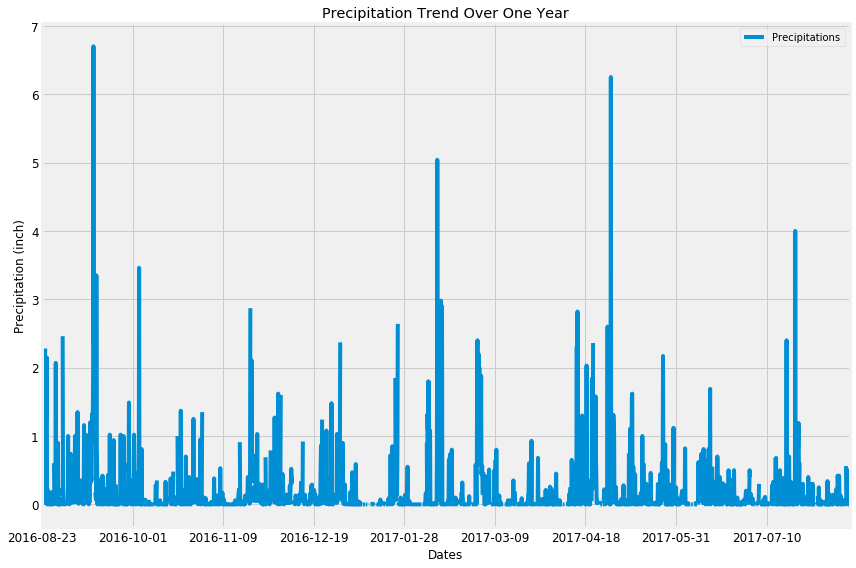

In [152]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot.line(title="Precipitation Trend Over One Year", fontsize = 12, figsize=(12,8))
#plt.xlabel('precipitation')
plt.ylabel('Precipitation (inch)')
plt.tight_layout()
plt.show()


![precipitation](Images/precipitation.png)

In [153]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitations
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

* Design a query to calculate the total number of stations.

In [154]:
# Design a query to show how many stations are available in this dataset?
count_stations = session.query(Measurement.station).\
    group_by(Measurement.station).count()
print("{} stations are available in this dataset.".format(count_stations))

9 stations are available in this dataset.


* Design a query to find the most active stations.
    * List the stations and observation counts in descending order.

In [155]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()                                 
active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

* Which station has the highest number of observations?

In [156]:
most_active= session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).first()                                 
print("The station {} has the highest number of observations with {} observations.".\
      format(most_active[0], most_active[1]))


The station USC00519281 has the highest number of observations with 2772 observations.


* For the station with the highest number of observations, calculate:
    * lowest, highest and average temperature recorded

In [258]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
query_temp = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active[0]).all()
print(query_temp)

print("The lowest temperature recorded is {}° F".format(query_temp[0][0]))
print("The highest temperature recorded is {}° F".format(query_temp[0][1]))
print("The average temperature recorded is {0:.1f}° F".format(query_temp[0][2]))


[(54.0, 85.0, 71.66378066378067)]
The lowest temperature recorded is 54.0° F
The highest temperature recorded is 85.0° F
The average temperature recorded is 71.7° F


* Design a query to retrieve the last 12 months of temperature observation data (tobs) for the same station

Text(0.5, 0, 'Temperatures (°F)')

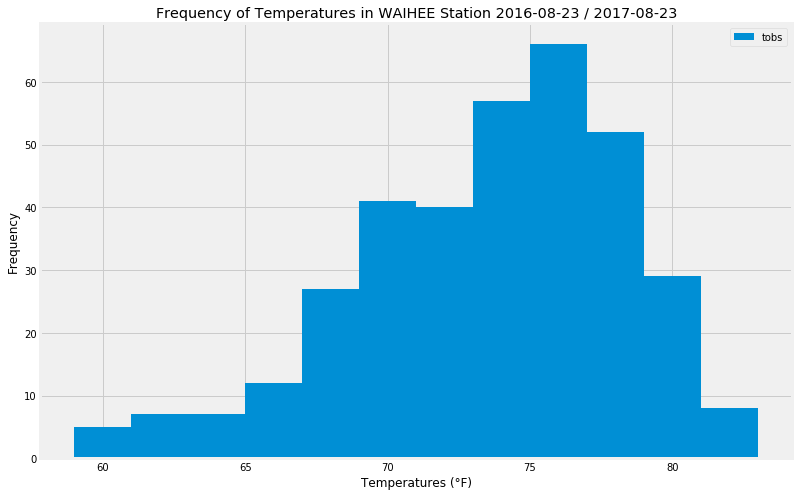

In [158]:
# Query the last 12 months of temperature observation data for the station with the highest number of temperature observations.
twelve_months = session.query(Measurement.tobs).\
    filter((Measurement.station == most_active[0]), (Measurement.date > first_date)).all()

# Convert the query results in a DataFrame
df_twelve = pd.DataFrame(twelve_months)

# Plot the results as a histogram

df_twelve.plot.hist(bins=12, title=f"Frequency of Temperatures in WAIHEE Station {first_date} / {last_date}",
                    figsize=(12,8))
plt.xlabel('Temperatures (°F)')


![precipitation](Images/station-histogram.png)

In [160]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))


[(62.0, 69.57142857142857, 74.0)]


In [315]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2017-07-14'
end_date = '2017-07-21'

tmin = calc_temps(start_date, end_date)[0][0]
#tavg = '%.1f' % round(calc_temps(start_date, end_date)[0][1],1)
tavg = calc_temps(start_date, end_date)[0][1]
tmax = calc_temps(start_date, end_date)[0][2]
print(tmin, tavg, tmax)
x = (f"{start_date} / {end_date}")


72.0 78.62745098039215 83.0


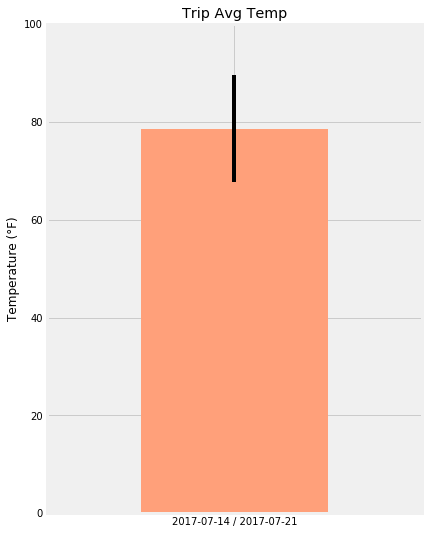

In [324]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

#plt.subplots()
plt.figure(figsize=(6,9))
plt.bar(x, tavg, width=0.5, align='center', yerr = (tmax-tmin), color='lightsalmon')
plt.title('Trip Avg Temp')
plt.ylabel('Temperature (°F)')
plt.xlim(-0.5,0.5)
plt.ylim(0,100)
plt.setp(ax.get_yticklabels(),ha="left")
#plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


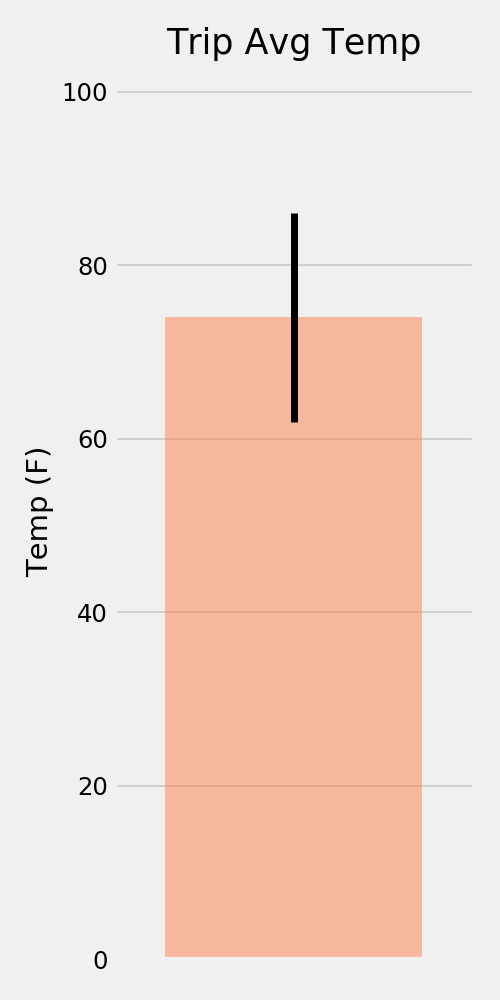

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [348]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2017-07-14'
end_date = '2017-07-21'
sel = [Station.station, Station.name, Station.latitude, 
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
rainfall = session.query(*sel).\
    group_by(Station.station).\
    order_by(func.sum(Measurement.prcp).desc()).\
    filter(Station.station == Measurement.station).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
for record in rainfall:
    print(record)
    (st_st, st_name, st_lat, st_lon, st_elev, mea_prcp) = record
     

('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 5.14)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.75)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.42000000000000004)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.38)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.33)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.15000000000000002)
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0)


In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation




[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


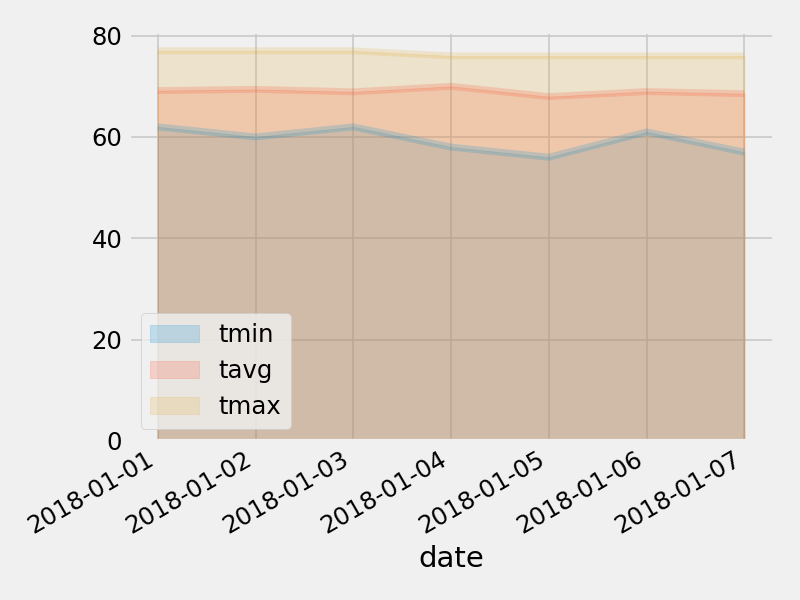

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
